# exiD (LevelX)

## About

The exiD dataset was created and published by a team from the Institute for Automotive Engineering (ika) of RWTH Aachen University to promote research in many different domains of mobility. The dataset can therefore be downloaded and used free of charge for academic and research purposes.

This dataset contains 92 separate recordings (more than 16 hours of video) with traffic at seven different measurement locations at entries and exits of the German Autobahn...The data also contains variations in form of different speed limits on the highways: four locations have no speed limit, two locations have a speed limit of 100 km/h and one location has a speed limit of 120 km/h.

### How to Apply

The exiD dataset is free for non-commercial use only. According to the license and protocols, as a third-party, we cannot share any form of this dataset online. Please visit [the official website](https://levelxdata.com/exid-dataset/) of exiD, fill in the application form and send your request.

### Citation

```latex
@inproceedings{exiD,
    title={The exiD Dataset: A Real-World Trajectory Dataset of Highly Interactive Highway Scenarios in Germany},
    author={Moers, Tobias and Vater, Lennart and Krajewski, Robert and Bock, Julian and Zlocki, Adrian and Eckstein, Lutz},
    booktitle={2022 IEEE Intelligent Vehicles Symposium (IV)},
    pages={958-964},
    year={2022},
    doi={10.1109/IV51971.2022.9827305}
}
```

## Data Analysis

> This part is independently conducted by Tactics2D.

According to meta records:

- Trajectory data files 00-18 are recorded in location 0 (denoted as exiD_0)
- Trajectory data files 19-38 are recorded in location 1 (denoted as exiD_1)
- Trajectory data files 39-52 are recorded in location 2 (denoted as exiD_2)
- Trajectory data files 53-60 are recorded in location 3 (denoted as exiD_3)
- Trajectory data files 61-72 are recorded in location 4 (denoted as exiD_4)
- Trajectory data files 73-77 are recorded in location 5 (denoted as exiD_5)
- Trajectory data files 78-92 are recorded in location 6 (denoted as exiD_6)

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#cccccc",
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
locations = dict()
dfs_meta = pd.DataFrame()
for i in range(93):
    df_meta = pd.read_csv("../../data/exiD/data/%02d_recordingMeta.csv" % i)
    locations[i] = df_meta["locationId"][0]
    dfs_meta = pd.concat([dfs_meta, df_meta], ignore_index=True)

In [4]:
dfs_track_meta = pd.DataFrame()
for i in range(93):
    df_track_meta = pd.read_csv("../../data/exiD/data/%02d_tracksMeta.csv" % i)
    df_track_meta["locationId"] = locations[i]
    df_track_meta["fileId"] = i
    dfs_track_meta = pd.concat([dfs_track_meta, df_track_meta], ignore_index=True)

In [5]:
dfs = [pl.DataFrame()] * 7

for i in range(93):
    df = pl.read_csv("../../data/exiD/data/%02d_tracks.csv" % i, ignore_errors=True)
    df = df.select(["trackId", "frame", "xCenter", "yCenter", "heading", "xVelocity", "yVelocity", "laneletId"])
    df = df.with_columns(pl.lit(i).alias("fileId"))
    df = df.join(
        pl.DataFrame(dfs_track_meta)[["fileId", "trackId", "class"]],
        on=["fileId", "trackId"],
        how="left",
    )
    if df.schema["laneletId"] == pl.Utf8:
        df = df.with_columns([
            df["laneletId"]
            .str.split(";")
            .list.get(0)
            .cast(pl.Int64, strict=False)
            .alias("laneletId")
        ])

    dfs[locations[i]] = pl.concat([dfs[locations[i]], df])

In [6]:
for i in range(7):
    x_min = np.floor(dfs[i]["xCenter"].min())
    x_max = np.ceil(dfs[i]["xCenter"].max())
    y_min = np.floor(dfs[i]["yCenter"].min())
    y_max = np.ceil(dfs[i]["yCenter"].max())
    vx = dfs[i]["xVelocity"].to_numpy()
    vy = dfs[i]["yVelocity"].to_numpy()

    x_edges_1 = np.linspace(x_min, x_max, num=int((x_max - x_min) * 10 + 1), endpoint=True)
    y_edges_1 = np.linspace(y_min, y_max, num=int((y_max - y_min) * 10 + 1), endpoint=True)
    x_bin_1 = np.digitize(dfs[i]["xCenter"].to_numpy(), x_edges_1) - 1
    y_bin_1 = np.digitize(dfs[i]["yCenter"].to_numpy(), y_edges_1) - 1
    x_edges_2 = np.linspace(x_min, x_max, num=int((x_max - x_min) * 2 + 1), endpoint=True)
    y_edges_2 = np.linspace(y_min, y_max, num=int((y_max - y_min) * 2 + 1), endpoint=True)
    x_bin_2 = np.digitize(dfs[i]["xCenter"].to_numpy(), x_edges_2) - 1
    y_bin_2 = np.digitize(dfs[i]["yCenter"].to_numpy(), y_edges_2) - 1
    speed = np.sqrt(vx**2 + vy**2)
    heading = np.arctan(vy / vx)

    dfs[i] = dfs[i].with_columns(
        [
            pl.Series("x_bin_1", x_bin_1),
            pl.Series("y_bin_1", y_bin_1),
            pl.Series("x_bin_2", x_bin_2),
            pl.Series("y_bin_2", y_bin_2),
            pl.Series("speed (m/s)", speed),
            pl.Series("heading (radian)", heading),
        ]
    )

### Distribution of Trajectory on Map

In exiD, all records are obtained in highway, so the trajectories all fall in vehicle types: `car`, `truck`, and `van`. 

![Trajectories on map](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/exiD.png)

### Distribution of Trajectory Categories

The proportions of each vehicle type vary significantly across different locations. Even within the same location, these proportions fluctuate within a certain range.

In [7]:
df_class_distribution = (
    dfs_track_meta.groupby(["locationId", "fileId"])["class"].value_counts(normalize=True).unstack(fill_value=0)
)
df_class_distribution = df_class_distribution.reset_index()
df_class_distribution["locationId"] = pd.Categorical(
    df_class_distribution["locationId"], categories=[0, 1,2,3,4,5,6], ordered=True
)

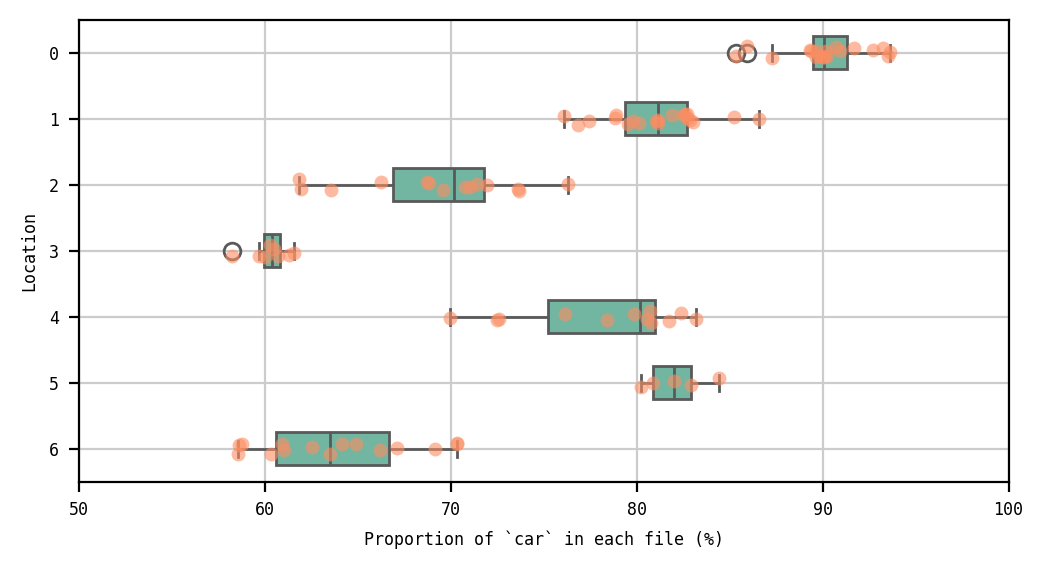

In [8]:
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=df_class_distribution, x="car", y="locationId", width=0.5, ax=ax)

sns.stripplot(data=df_class_distribution, x="car", y="locationId", alpha=0.6, ax=ax)

ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(["50", "60", "70", "80", "90", "100"])
ax.yaxis.grid(True)
ax.set_xlabel(
    "Proportion of `car` in each file (%)"
)
ax.set_ylabel("Location")
plt.show()

### Distribution of Average Speed on Map

The speed heatmap exhibits a characteristic highway speed distribution. Outer lanes (leftmost) display reduced average speeds relative to inner lanes (rightmost), consistent with typical lane usage patterns. Additionally, speeds are notably lower at highway entry points, reflecting acceleration behavior as vehicles merge into the main traffic flow.

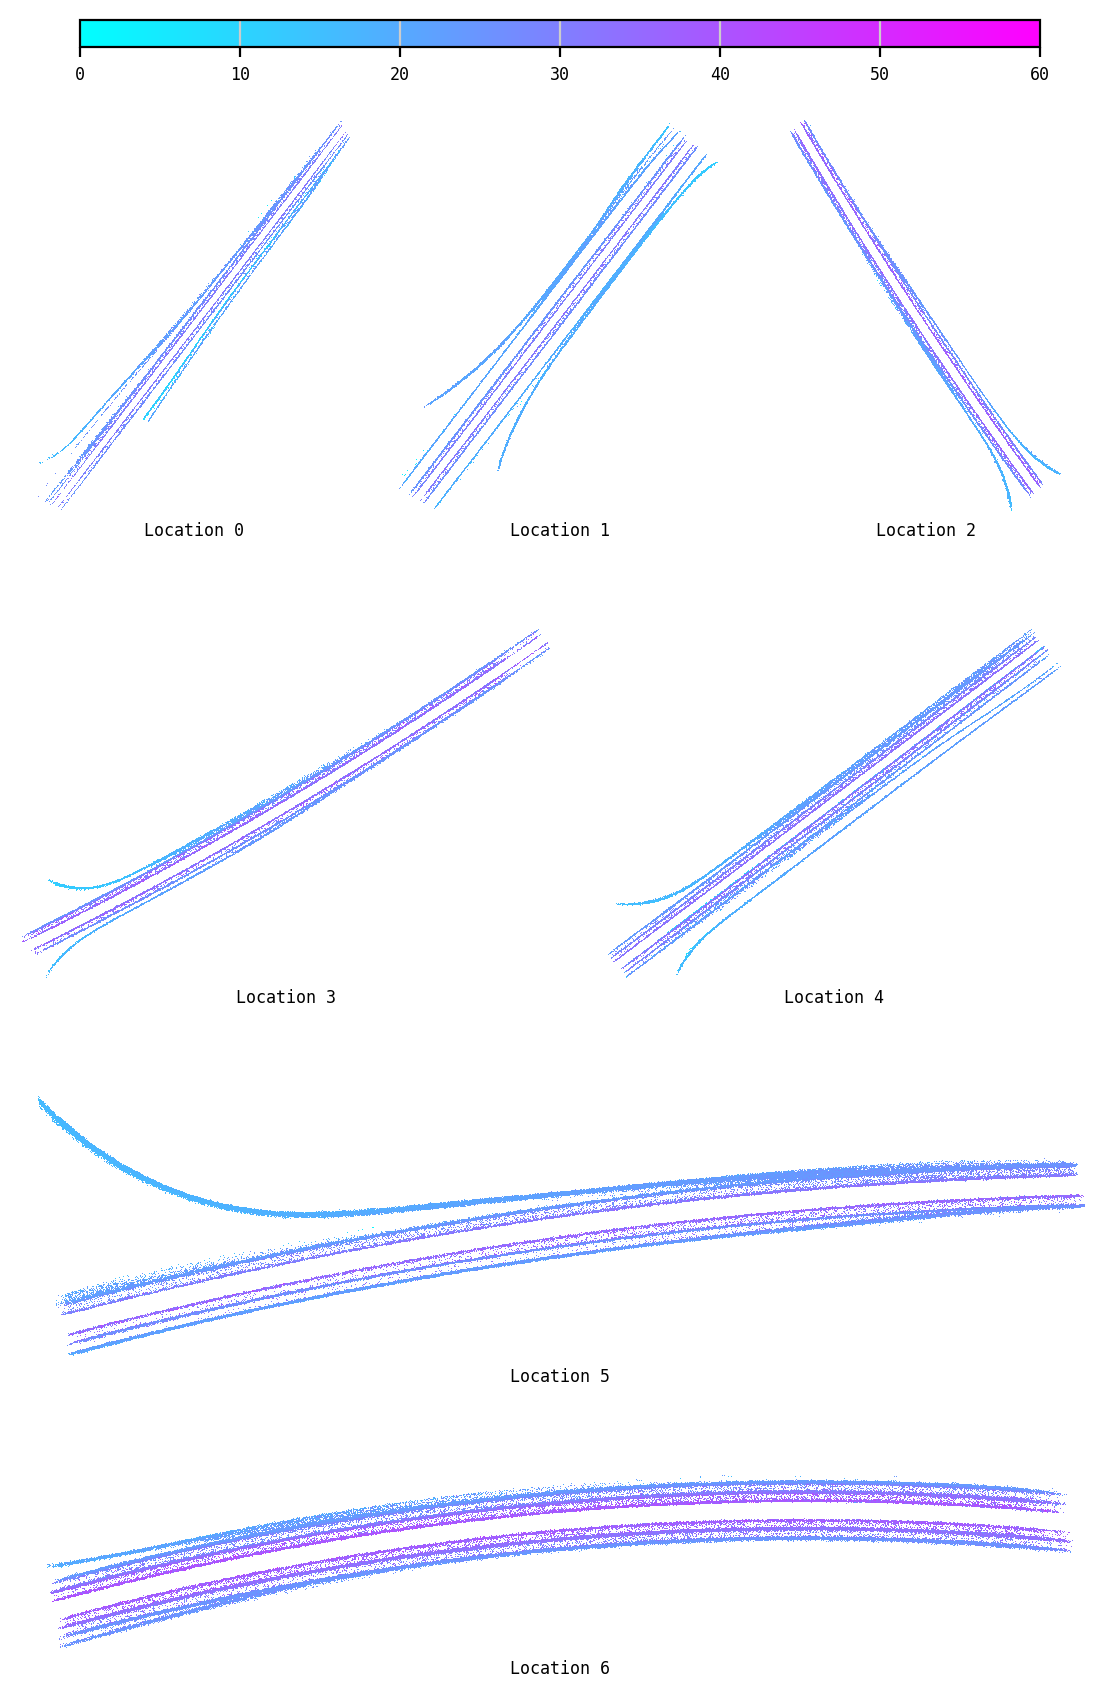

In [9]:
fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(4, 6, figure=fig, height_ratios=[9, 8, 6, 4])

fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1, hspace=0.4)

positions = [
    (0, 0, 2), (0, 2, 4), (0, 4, 6), 
    (1, 0, 3), (1, 3, 6),
    (2, 0, 6),
    (3, 0, 6),
]

axes = []
for i in range(7):
    row, start_col, end_col = positions[i]
    ax = fig.add_subplot(gs[row, start_col:end_col])

    df_speed_heatmap = (
        dfs[i]
        .group_by(["y_bin_1", "x_bin_1"])
        .agg(pl.col("speed (m/s)").mean().alias("avg_speed"))
        .sort(["y_bin_1", "x_bin_1"])
    ).to_pandas()

    grid = df_speed_heatmap.pivot(index="y_bin_1", columns="x_bin_1", values="avg_speed")

    hm = sns.heatmap(
        grid,
        ax=ax,
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=60,
    )

    ax.set_aspect("equal")
    ax.set_xlabel(f"Location {i}")
    ax.set_ylabel("")
    axes.append(ax)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.015])
fig.colorbar(axes[-1].collections[0], cax=cbar_ax, orientation="horizontal")

plt.show()

### 

### Distribution of Lane Change Frequency on Map

The figure illustrates the cumulative count of lane-changing events within each predefined grid cell on the map. Lane changes are relatively evenly distributed along the main highway lanes, while sharp increases in lane-changing activity are observed near entrances, exits, merge, and diverge areas.

Maximum lane changing in one grid (location 0): 549
Maximum lane changing in one grid (location 1): 732
Maximum lane changing in one grid (location 2): 771
Maximum lane changing in one grid (location 3): 454
Maximum lane changing in one grid (location 4): 648
Maximum lane changing in one grid (location 5): 405
Maximum lane changing in one grid (location 6): 482


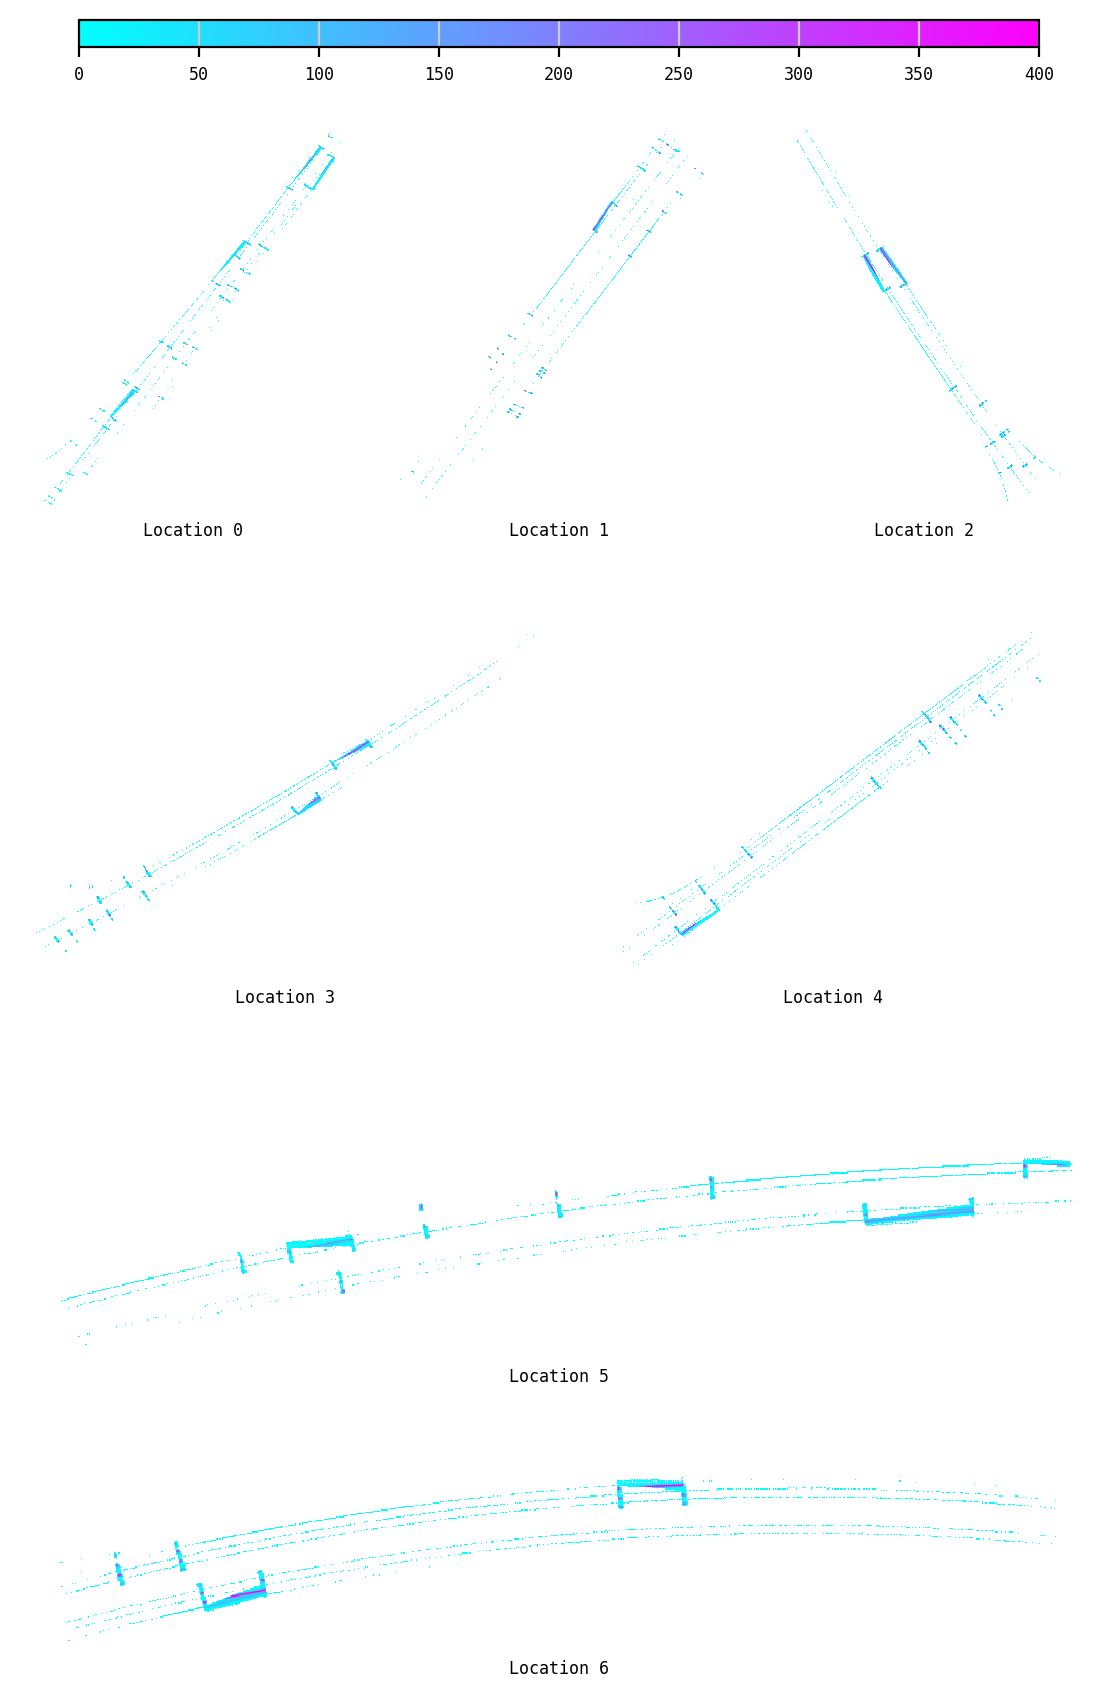

In [10]:
fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(4, 6, figure=fig, height_ratios=[9, 8, 6, 4])

fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1, hspace=0.4)

positions = [
    (0, 0, 2), (0, 2, 4), (0, 4, 6), 
    (1, 0, 3), (1, 3, 6),
    (2, 0, 6),
    (3, 0, 6),
]

axes = []
for i in range(7):
    row, start_col, end_col = positions[i]
    ax = fig.add_subplot(gs[row, start_col:end_col])

    df_lane_changing = dfs[i].to_pandas()
    df_lane_changing = df_lane_changing.sort_values(by=["fileId", "trackId", "frame"])
    df_lane_changing["prev_laneletId"] = df_lane_changing.groupby(["fileId", "trackId"])["laneletId"].shift(1)
    df_lane_changing["laneChange"] = (
        df_lane_changing["laneletId"] != df_lane_changing["prev_laneletId"]
    ).astype(int)
    first_row_mask = df_lane_changing.groupby(["fileId", "trackId"]).cumcount() == 0
    df_lane_changing.loc[first_row_mask, "laneChange"] = 0
    df_lane_changing_heatmap = (
        df_lane_changing.groupby(["y_bin_2", "x_bin_2"])["laneChange"].sum().unstack(fill_value=0)
    )
    print(f"Maximum lane changing in one grid (location {i}): {df_lane_changing_heatmap.to_numpy().max()}")
    mask = df_lane_changing_heatmap == 0
    hm = sns.heatmap(
        df_lane_changing_heatmap,
        mask=mask,
        ax=ax,
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=400,
    )

    ax.set_aspect("equal")
    ax.set_xlabel(f"Location {i}")
    ax.set_ylabel("")
    axes.append(ax)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.015])
fig.colorbar(axes[-1].collections[0], cax=cbar_ax, orientation="horizontal")

plt.show()

### Distribution of Speed by Trajectory Type

Different trajectory types exhibit peak speeds at distinct values. Cars typically demonstrate the highest average speeds, followed closely by vans, while trucks display significantly lower speeds. The speed profiles for each vehicle type remain relatively consistent across locations, suggesting that the highway scenarios represented in the exiD dataset are largely homogeneous.

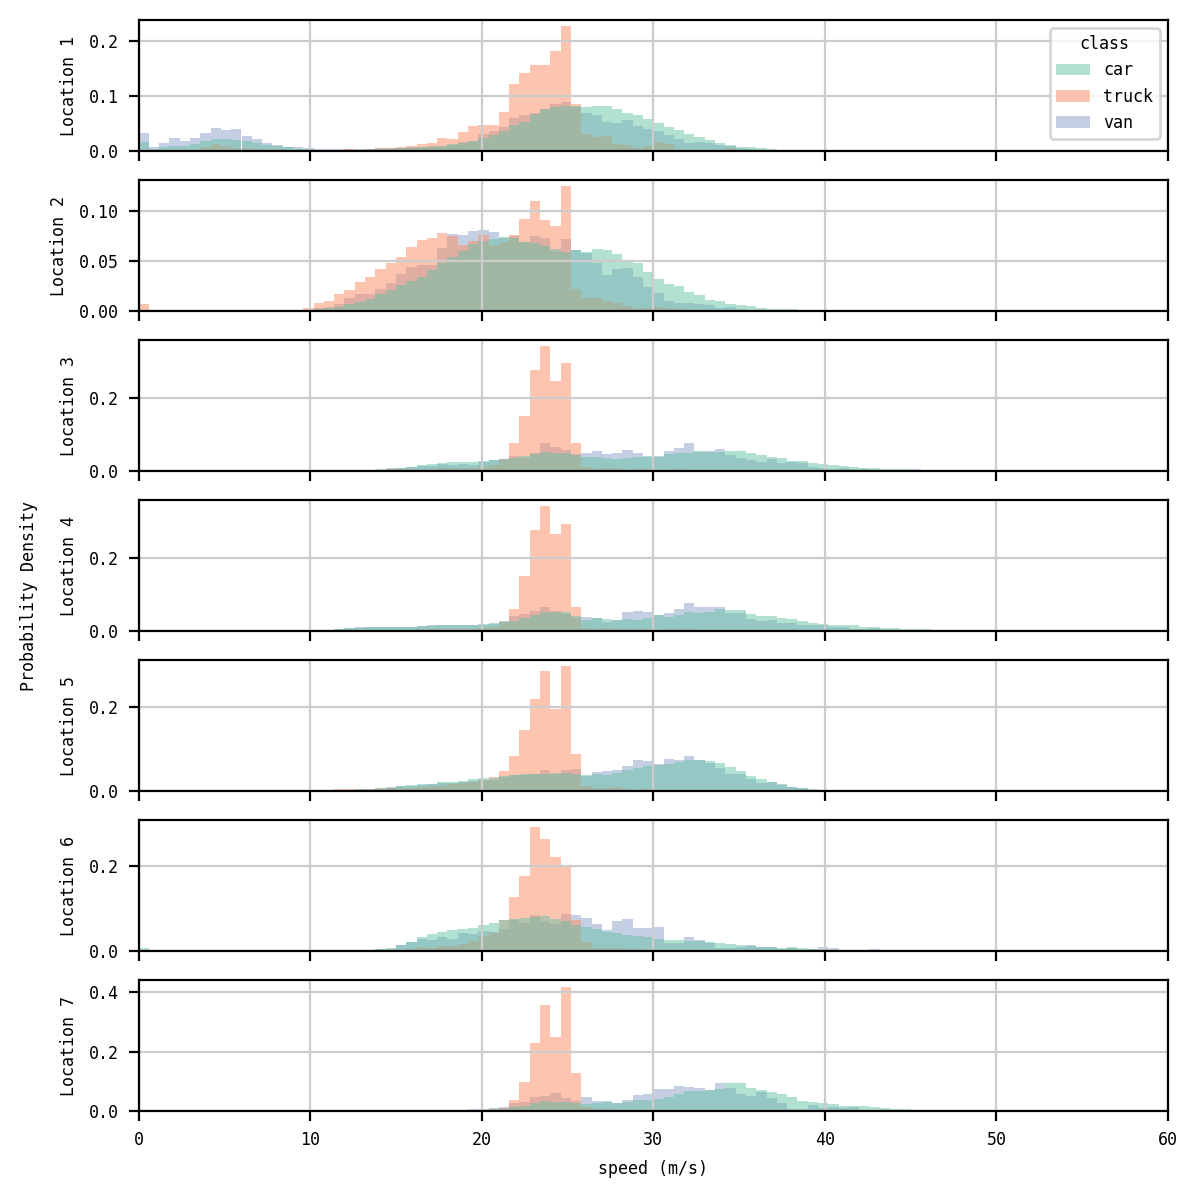

In [11]:
fig, axes = plt.subplots(7, 1, figsize=(6, 6), sharex=True)
for i in range(7):
    df_speed = dfs[i].to_pandas()

    sns.histplot(
        df_speed,
        x="speed (m/s)",
        hue="class",
        hue_order=["car", "truck", "van"],
        multiple="layer",
        palette="Set2",
        ax=axes[i],
        stat="density",
        common_norm=False,
        binwidth=0.6,
        binrange=(0, 60),
        linewidth=0,
        alpha=0.5,
        legend=(i == 0),
    )

    axes[i].set_xlim([0, 60])
    axes[i].set_ylabel(f"Location {i+1}")

fig.text(0.02, 0.5, "Probability Density", va="center", rotation="vertical")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

## Tactics2D Integration

### Class Mapping

| Class | Tactics2D |
| --- | --- |
| car | `tactics2d.participant.element.Vehicle` |
| truck | `tactics2d.participant.element.Vehicle` |
| van | `tactics2d.participant.element.Vehicle` |

In [12]:
# TODO: Mitigate later

## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://levelxdata.com/wp-content/uploads/2024/03/exiD-Format_2_1.pdf" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

The dataset includes measurement data extracted from one or more recording sites (locations) in the data directory as well as map files per location in the maps directory (if part of the dataset). Data and maps can be associated using a recording's location id. The data for each location is split into multiple continuous recordings.

In total four files are provided for each recording:

- An image of the recorded road section (XX_background.png)
- A csv file describing the recording location (XX_recordingsMeta.csv)
- A csv file containing an overview of recorded vehicle and VRU tracks (XX_tracksMeta.csv)
- A csv file for the tracks' trajectories (XX_tracks.csv)
    These files are created for each recording to ensure easy handling of the data.

In addition the following map data for each recording location are provided:

- Lanelet2 maps (.osm)
- ASAM OpenDrive maps (.xodr)
- 3D scene (.osgb & .fbx)

In the following, the dataset format and especially the meaning of every column is explained in
detail.

Please note that we summarize pedestrians, bicyclists and motorcycles to vulnerable road users
(VRUs) in the following tables.

### Image of the Road Section

For each recording a georeferenced image of the road section is added.The image is based on the recording itself by removing all moving vehicles through filtering. Additionally the resolution of the image was reduced.

### Recording Meta Information

This file contains metadata for each recording. The metadata provides a general overview, e.g. of the time of recording, the road section considered and the total number of objects tracked.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| locationId | The id of the recording location. | [-] | 
| frameRate | The frame rate which was used to record the video. | [hz] |
| speedLimit | The speed limit of the driving lanes. In all recordings, the speed limit is the same for every driving lane. | [m/s] |
| weekday | The weekday the recording was done. | [-] |
| startTime | The hour at which the recording was started | [hh] |
| duration | The duration of the recording. | [s] |
| numTracks | The number of objects tracked. | [-] |
| numVehicles | The number of vehicles tracked. | [-] |
| numVrus | The number of vulnerable road users (VRUs) tracked. | [-] |
| latLocation | Rough latitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| lonLocation | Rough longitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| xUtmOrigin | X value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to xCenter to get UTM coordinates. | [m] |
| yUtmOrigin | Y value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to yCenter to get UTM coordinates. | [m] |
| orthoPxToMeter | Scale factor from ortho image pixels to UTM meters. This value is needed for visualization. | [m/px] |
| exportVersion | Version of data format. (may be missing in some datasets) | [-] |

### Track Meta Information

This file contains an overview of all tracks.

The purpose of this file is to allow filtering tracks e.g. by class.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The id of the track. The ids are assigned in ascending order for each recording. | [-] |
| initialFrame | The frame in which the track starts. | [-] |
| finalFrame | The frame in which the track ends. | [-] |
| numFrames | The total lifetime in frames. | [-] |
| width | The width of the tracked object. This property is set to zero for VRUs. | [m] |
| length | The length of the tracked object. This property is set to zero for VRUs. | [m] |
| class | The class of the tracked object. | [-] |

### Tracks

This file contains all time dependent values for each track. Information such as current position, velocity and acceleration.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The track's id. The ids are assigned in ascending order for each recording. | [-] |
| frame | The frame for which the information are given. | [-] |
| trackLifetime | The current age of the track at this frame. | [-] |
| xCenter | The x position of the object's centroid in the local coordinate system. Add xUtmOrigin to get UTM coordinates. | [m] |
| yCenter | The y position of the object's centroid in the local coordinate system. Add yUtmOrigin to get UTM coordinates. | [m] |
| heading | The heading in the local coordinate system. | [deg] |
| width | The width of the object. This property is set to zero for VRUs. | [m] |
| length | The height of the object. This property is set to zero for VRUs. | [m] |
| xVelocity | The velocity in x-axis direction in the local coordinate system. | [m/s] |
| yVelocity | The velocity in y-axis direction in the local coordinate system. | [m/s] |
| xAcceleration | The acceleration in x-axis direction in the local coordinate system. | [m/s²] |
| yAcceleration | The acceleration in y-axis direction in the local coordinate system. | [m/s²] |
| lonVelocity | The longitudinal velocity. | [m/s] |
| latVelocity | The lateral velocity. | [m/s] |
| lonAcceleration | The longitudinal acceleration. | [m/s²] |
| latAcceleration | The lateral acceleration. | [m/s²] |

### Coordinate System

The global coordinate system used is the UTM coordinate system, as we geo-referenced our data. For easier handling of data of the same intersection in different recordings, we introduced a local UTM-like coordinate system.

The only difference is, that the origin (0, 0) is very close to the recorded road section and the same for all recordings at each location.

To transform positions into the global UTM coordinate system, just add xUtmOrigin and yUtmOrigin to all positions.

The local coordinate system looks as follows: The horizontal axis is the x-axis, which grows to the right.

The vertical axis is the y-axis, which grows upwards.

The heading is calcuated as in the UTM coordinate system.

Finally, we use SI units only.

![The coordinate system of exiD dataset](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/exiD-coordinate-system.png)